# Connecting Google Drive and import necessary libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import chess.pgn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import chess
from networkx.algorithms import bipartite
import itertools
from collections import Counter
import re

# open file and read into df

In [ ]:
pgn_file = open("/content/drive/My Drive/lichess4545-all-s01-33.pgn")
game = chess.pgn.read_game(pgn_file)

data = []

while game:
    headers = game.headers

    eco = headers.get("ECO", "NoECO")  # Use the get() method to get the value of "ECO", or return "NoECO" if it doesn't exist
    data.append({
        "Date": headers["Date"],
        "White": headers["White"],
        "Black": headers["Black"],
        "WhiteElo": headers["WhiteElo"],
        "BlackElo": headers["BlackElo"],
        "ECO": eco,  # Use the value of ECO variable
        "Result": headers["Result"],
    })

    game = chess.pgn.read_game(pgn_file)

df = pd.DataFrame(data)

In [ ]:
df

Date               White          Black WhiteElo BlackElo  ECO  \
0      2015.11.01               JTate         theino     1796     1868  E11   
1      2015.11.01           sprite143   MrLegilimens     1648     1602  A46   
2      2015.11.01             buubble       icendoan     1400     1548  B01   
3      2015.11.01             zezetel        Baybars     1608     1554  B77   
4      2015.10.31  CheapEndgameTricks          mkoga     1654     1754  B12   
...           ...                 ...            ...      ...      ...  ...   
31183  2023.01.24             b_elyay         NLance     2062     2070  C67   
31184  2023.01.23                M0r1  Astronominoff     1985     1996  B00   
31185  2023.01.23            pafiedor         glbert     1857     1895  D11   
31186  2023.01.23             izcms02       aerdna69     1878     1886  D30   
31187  2023.01.23    Poldi_der_Drache          mo_mo     2006     1975  B01   

        Result  
0          1-0  
1      1/2-1/2  
2          0-1  
3          0-1  
4          0-1  
...        ...  
31183      0-1  
31184      0-1  
31185      1-0  
31186      1-0  
31187      0-1  

[31188 rows x 7 columns]

# Arrange Data

Reversed dataframe because the last Elo scores will be taken into account when creating the network.

In [ ]:
df = df.iloc[::-1]
df

Date               White          Black WhiteElo BlackElo  ECO  \
31187  2023.01.23    Poldi_der_Drache          mo_mo     2006     1975  B01   
31186  2023.01.23             izcms02       aerdna69     1878     1886  D30   
31185  2023.01.23            pafiedor         glbert     1857     1895  D11   
31184  2023.01.23                M0r1  Astronominoff     1985     1996  B00   
31183  2023.01.24             b_elyay         NLance     2062     2070  C67   
...           ...                 ...            ...      ...      ...  ...   
4      2015.10.31  CheapEndgameTricks          mkoga     1654     1754  B12   
3      2015.11.01             zezetel        Baybars     1608     1554  B77   
2      2015.11.01             buubble       icendoan     1400     1548  B01   
1      2015.11.01           sprite143   MrLegilimens     1648     1602  A46   
0      2015.11.01               JTate         theino     1796     1868  E11   

        Result  
31187      0-1  
31186      1-0  
31185      1-0  
31184      0-1  
31183      0-1  
...        ...  
4          0-1  
3          0-1  
2          0-1  
1      1/2-1/2  
0          1-0  

[31188 rows x 7 columns]

When we look at the table below, we can see that Elo scores are kept as strings. We need to convert these scores to integers.

In [ ]:
print(df.applymap(type))

                Date          White          Black       WhiteElo  \
31187  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31186  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31185  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31184  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31183  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
...              ...            ...            ...            ...   
4      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
3      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
2      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
1      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
0      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   

            BlackElo            ECO         Result  
31187  <class 'str'>  <class 'str'>  <class 'str'>  
31186  <class 'str'>  <class 'str'>  <class 'str'>  
31185  <clas

In [ ]:
df['WhiteElo'] = df['WhiteElo'].astype(int)
df['BlackElo'] = df['BlackElo'].astype(int)

In [ ]:
count_no_opening = df[df['ECO'] == 'NoECO'].shape[0]
print("Number of 'NoECO's:", count_no_opening)

Number of 'NoECO's: 0


Each game has the information of "ECO", therefore there is no need to exclude any game from the dataset.

# Examine the data

There are 3498 players in the dataset:

In [ ]:
players = pd.concat([df['White'], df['Black']]).unique()
print(len(players))

3498


There are 473 openings:

In [ ]:
openings = df["ECO"].unique()
print(len(openings))

473


In [ ]:
print(df["ECO"].unique())

['B01' 'D30' 'D11' 'B00' 'C67' 'B12' 'A45' 'B33' 'B21' 'B30' 'A04' 'D00'
 'E12' 'A01' 'C82' 'E04' 'C01' 'D85' 'C47' 'B22' 'C74' 'B10' 'B27' 'E77'
 'D01' 'E38' 'B15' 'C51' 'C55' 'C45' 'D31' 'D15' 'A37' 'C60' 'C00' 'C88'
 'B99' 'B06' 'B13' 'D92' 'A84' 'D10' 'B36' 'B51' 'A96' 'C69' 'C65' 'D35'
 'C02' 'A10' 'D45' 'A48' 'C24' 'A57' 'D91' 'A20' 'E61' 'D87' 'C77' 'A02'
 'C53' 'C43' 'C33' 'E49' 'C46' 'B32' 'A09' 'C42' 'A40' 'B14' 'D37' 'A14'
 'D02' 'A35' 'B31' 'C92' 'D43' 'E06' 'A18' 'D20' 'A23' 'B46' 'B48' 'E35'
 'C36' 'B38' 'B90' 'C28' 'B94' 'D78' 'D41' 'E73' 'A05' 'B23' 'E01' 'B20'
 'B40' 'B35' 'B02' 'B44' 'D05' 'E14' 'E94' 'A22' 'A58' 'B69' 'E30' 'C06'
 'B25' 'D59' 'E15' 'D04' 'A06' 'C21' 'C44' 'C50' 'B08' 'C25' 'E20' 'A00'
 'C10' 'B39' 'A36' 'D21' 'A16' 'C29' 'D40' 'D34' 'B11' 'A30' 'C09' 'B03'
 'C80' 'A80' 'B24' 'B07' 'D07' 'A07' 'D96' 'B17' 'E19' 'E48' 'B50' 'B56'
 'A68' 'D81' 'C26' 'C87' 'B42' 'D50' 'D80' 'C63' 'D44' 'E43' 'E11' 'C15'
 'E46' 'C05' 'A31' 'D13' 'E64' 'A85' 'D27' 'D32' 'B

In [ ]:
# Create a dictionary to store player's latest Elo
latest_elo = {}

# Iterate over the rows of the DataFrame
for idx, row in df.iterrows():
    # If this is a more recent game for the white player, update their Elo
    if row['White'] not in latest_elo or idx > latest_elo[row['White']][0]:
        latest_elo[row['White']] = (idx, row['WhiteElo'])
    # Same for the black player
    if row['Black'] not in latest_elo or idx > latest_elo[row['Black']][0]:
        latest_elo[row['Black']] = (idx, row['BlackElo'])

# Now count the players in each Elo range
elo_ranges = [(800, 1200), (1201, 1600), (1601, 2000), (2001, 2400)]
counts = [0, 0, 0, 0]
for player, (idx, elo) in latest_elo.items():
    for i, elo_range in enumerate(elo_ranges):
        if elo_range[0] <= elo <= elo_range[1]:
            counts[i] += 1
            break  # A player can be in only one range, so move to next player

# Print the counts
for i, elo_range in enumerate(elo_ranges):
    print(f"Number of unique players with Elo between {elo_range[0]} and {elo_range[1]}: {counts[i]}")


Number of unique players with Elo between 800 and 1200: 21
Number of unique players with Elo between 1201 and 1600: 524
Number of unique players with Elo between 1601 and 2000: 2059
Number of unique players with Elo between 2001 and 2400: 886


8 players are out of scope (the result is 3490 in total). But there are 3498 players

In [ ]:
df['WhiteElo'] = df['WhiteElo'].astype(int)
df['BlackElo'] = df['BlackElo'].astype(int)

max_white_elo = df['WhiteElo'].max()
print(f"Maximum WhiteElo: {max_white_elo}")
min_white_elo = df['WhiteElo'].min()
print(f"Minimum WhiteElo: {min_white_elo}")

Maximum WhiteElo: 2549
Minimum WhiteElo: 802


In [ ]:
df['BlackElo'] = df['BlackElo'].astype(int)

max_black_elo = df['BlackElo'].max()
print(f"Maximum BlackElo: {max_black_elo}")

min_black_elo = df['BlackElo'].min()
print(f"Minimum BlackElo: {min_black_elo}")

Maximum BlackElo: 2641
Minimum BlackElo: 806


# Create Network

## Bipartite Opening - Player Network

In [ ]:
B = nx.Graph()

# Add nodes with the player attribute "bipartite=0", and attribute label="player"
B.add_nodes_from(df['White'].unique(), bipartite=0, label='player', elo=0)
B.add_nodes_from(df['Black'].unique(), bipartite=0, label='player', elo=0)

# Add nodes with the opening attribute "bipartite=1", and attribute label="ECO"
B.add_nodes_from(df['ECO'].unique(), bipartite=1, label='ECO', ECOtype=None,
                 elo_800_1200=0, elo_1201_1600=0, elo_1601_2000=0, elo_2001_2400=0)

# Add edges between players and openings
for index, row in df.iterrows():
    white_player, black_player, opening = row['White'], row['Black'], row['ECO']
    white_elo, black_elo = row['WhiteElo'], row['BlackElo']

    # White player
    if B.has_edge(white_player, opening):
        B[white_player][opening]['weight'] += 1
    else:
        B.add_edge(white_player, opening, weight=1)

    # Black player
    if B.has_edge(black_player, opening):
        B[black_player][opening]['weight'] += 1
    else:
        B.add_edge(black_player, opening, weight=1)

    # Update Elo scores if they are equal to 0
    if B.nodes[white_player]['elo'] == 0:
        B.nodes[white_player]['elo'] = white_elo
    if B.nodes[black_player]['elo'] == 0:
        B.nodes[black_player]['elo'] = black_elo

    # Update ECOtype attribute within the loop
    if B.nodes[opening]['ECOtype'] is None:
        B.nodes[opening]['ECOtype'] = opening[0]

    # Update the ECO node attributes based on the Elo ratings of the players
    for player_elo in [white_elo, black_elo]:
        if 800 <= player_elo <= 1200:
            B.nodes[opening]['elo_800_1200'] += 1
        elif 1201 <= player_elo <= 1600:
            B.nodes[opening]['elo_1201_1600'] += 1
        elif 1601 <= player_elo <= 2000:
            B.nodes[opening]['elo_1601_2000'] += 1
        elif 2001 <= player_elo <= 2400:
            B.nodes[opening]['elo_2001_2400'] += 1

In [ ]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(B))  # Supposed to be True

True


In [ ]:
nx.write_gexf(B, "/content/drive/My Drive/BiperGraph.gexf", encoding='utf-8')

## Project players from the graph

In [ ]:
# Project the player nodes from the bipartite graph
player_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 0}
player_projected_graph = nx.bipartite.projected_graph(B, player_nodes)

In [ ]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(player_projected_graph))  # Supposed to be False

False


In [ ]:
nx.write_gexf(player_projected_graph, "/content/drive/My Drive/PlayerProjectedGraph.gexf", encoding='utf-8')

## Project ECOs from the Graph

In [ ]:
# Project the ECO nodes from the bipartite graph
ECO_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 1}
ECO_projected_graph = nx.bipartite.projected_graph(B, ECO_nodes)

In [ ]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(ECO_projected_graph))  # Supposed to be False

False


In [ ]:
nx.write_gexf(ECO_projected_graph, "/content/drive/My Drive/OpeningProjectedGraph.gexf", encoding='utf-8')

## Projection of openings based on ECO Type (A/B/C/D/E)

In [ ]:
ECO_projected_graphs = {}

for eco_type in ['A', 'B', 'C', 'D', 'E']:
    # Filter ECO nodes with the given ECOtype
    filtered_ECO_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 1 and data['ECOtype'] == eco_type}

    # Project the filtered ECO nodes from the bipartite graph
    ECO_projected_graph = nx.bipartite.projected_graph(B, filtered_ECO_nodes)

    # Save the projected graph to the dictionary with the key as the ECOtype
    ECO_projected_graphs[eco_type] = ECO_projected_graph

# Save each ECO type projection to a separate variable
ECO_A_projected_graph = ECO_projected_graphs['A']
ECO_B_projected_graph = ECO_projected_graphs['B']
ECO_C_projected_graph = ECO_projected_graphs['C']
ECO_D_projected_graph = ECO_projected_graphs['D']
ECO_E_projected_graph = ECO_projected_graphs['E']


In [ ]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(ECO_A_projected_graph))  # Supposed to be False

False


In [ ]:
nx.write_gexf(ECO_A_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_A.gexf", encoding='utf-8')
nx.write_gexf(ECO_B_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_B.gexf", encoding='utf-8')
nx.write_gexf(ECO_C_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_C.gexf", encoding='utf-8')
nx.write_gexf(ECO_D_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_D.gexf", encoding='utf-8')
nx.write_gexf(ECO_E_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_E.gexf", encoding='utf-8')

## Projection of Players based on Elo Ratings (800-1200/1201-1600/1601-2000/2001-2400)

In [ ]:
player_projected_graphs = {}

elo_ranges = [
    (800, 1200),
    (1201, 1600),
    (1601, 2000),
    (2001, 2400),
]

for elo_range in elo_ranges:
    min_elo, max_elo = elo_range

    # Filter player nodes within the given Elo range
    filtered_player_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 0 and min_elo <= data['elo'] <= max_elo}

    # Project the filtered player nodes from the bipartite graph
    player_projected_graph = nx.bipartite.projected_graph(B, filtered_player_nodes)

    # Save the projected graph to the dictionary with the key as the Elo range
    player_projected_graphs[elo_range] = player_projected_graph

# Save each Elo range projection to a separate variable
players_800_1200_projected_graph = player_projected_graphs[(800, 1200)]
players_1201_1600_projected_graph = player_projected_graphs[(1201, 1600)]
players_1601_2000_projected_graph = player_projected_graphs[(1601, 2000)]
players_2001_2400_projected_graph = player_projected_graphs[(2001, 2400)]

In [ ]:
nx.write_gexf(players_800_1200_projected_graph, "/content/drive/My Drive/players_800_1200_projected_graph.gexf", encoding='utf-8')
nx.write_gexf(players_1201_1600_projected_graph, "/content/drive/My Drive/players_1201_1600_projected_graph.gexf", encoding='utf-8')
nx.write_gexf(players_1601_2000_projected_graph, "/content/drive/My Drive/players_1601_2000_projected_graph.gexf", encoding='utf-8')
nx.write_gexf(players_2001_2400_projected_graph, "/content/drive/My Drive/players_2001_2400_projected_graph.gexf", encoding='utf-8')

#__________________________________________

# Distribution of openings based on elo scores

In [ ]:
# Iterate over nodes and print information
for node, node_attrs in B.nodes(data=True):
    print("Node:", node)
    print("Attributes:", node_attrs)
    print()

    # If the node is a player
    if node_attrs['label'] == 'player':
        print("Player ELO:", node_attrs['elo'])

    # If the node is an opening
    elif node_attrs['label'] == 'ECO':
        print("ECO Type:", node_attrs['ECOtype'])
        print("ELO 800-1200:", node_attrs['elo_800_1200'])
        print("ELO 1201-1600:", node_attrs['elo_1201_1600'])
        print("ELO 1601-2000:", node_attrs['elo_1601_2000'])
        print("ELO 2001-2400:", node_attrs['elo_2001_2400'])

    print("============================")

Görüntülenen çıkış son 5000 satıra kısaltıldı.

Player ELO: 1961
Node: raffhawk
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1798}

Player ELO: 1798
Node: Trichord
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1925}

Player ELO: 1925
Node: Andy45
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 2025}

Player ELO: 2025
Node: TexasKnights
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1753}

Player ELO: 1753
Node: yigg
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1847}

Player ELO: 1847
Node: Waste-of-time
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 2164}

Player ELO: 2164
Node: JustOkay
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1883}

Player ELO: 1883
Node: Sasha-NBO
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1582}

Player ELO: 1582
Node: TamPham
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1951}

Player ELO: 1951
Node: jaegern2018
Attributes: {'bipartite': 0, 'label': 'player', 'elo': 1690}

Player

In [ ]:
# Create the dictionary to store the data
eco_data = {
    "A": {"elo_800_1200": 0, "elo_1201_1600": 0, "elo_1601_2000": 0, "elo_2001_2400": 0},
    "B": {"elo_800_1200": 0, "elo_1201_1600": 0, "elo_1601_2000": 0, "elo_2001_2400": 0},
    "C": {"elo_800_1200": 0, "elo_1201_1600": 0, "elo_1601_2000": 0, "elo_2001_2400": 0},
    "D": {"elo_800_1200": 0, "elo_1201_1600": 0, "elo_1601_2000": 0, "elo_2001_2400": 0},
    "E": {"elo_800_1200": 0, "elo_1201_1600": 0, "elo_1601_2000": 0, "elo_2001_2400": 0}
}

# Iterate through the nodes and update the fields based on ECO type
for node, node_attrs in B.nodes(data=True):
    if node_attrs['label'] == 'ECO':
        eco_type = node_attrs['ECOtype']
        elo_data = eco_data[eco_type]
        elo_data['elo_800_1200'] += node_attrs['elo_800_1200']
        elo_data['elo_1201_1600'] += node_attrs['elo_1201_1600']
        elo_data['elo_1601_2000'] += node_attrs['elo_1601_2000']
        elo_data['elo_2001_2400'] += node_attrs['elo_2001_2400']


In [ ]:
# Print the eco_data dictionary
print(eco_data)

{'A': {'elo_800_1200': 54, 'elo_1201_1600': 1293, 'elo_1601_2000': 7458, 'elo_2001_2400': 3366}, 'B': {'elo_800_1200': 65, 'elo_1201_1600': 2524, 'elo_1601_2000': 12017, 'elo_2001_2400': 4827}, 'C': {'elo_800_1200': 105, 'elo_1201_1600': 2278, 'elo_1601_2000': 8817, 'elo_2001_2400': 3002}, 'D': {'elo_800_1200': 44, 'elo_1201_1600': 1611, 'elo_1601_2000': 6993, 'elo_2001_2400': 2745}, 'E': {'elo_800_1200': 8, 'elo_1201_1600': 412, 'elo_1601_2000': 2971, 'elo_2001_2400': 1649}}


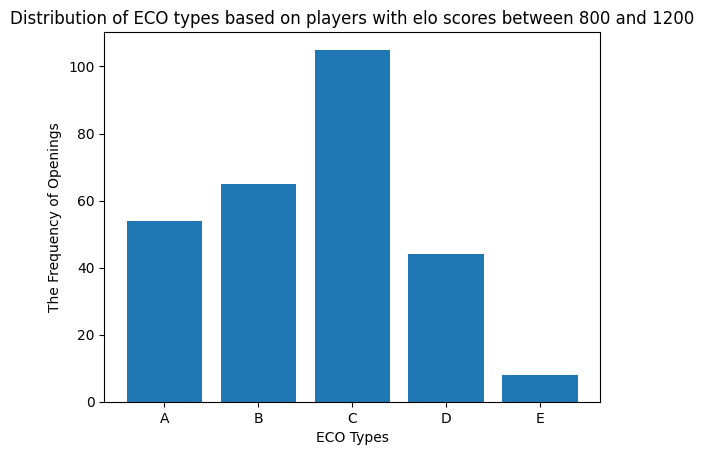

In [ ]:
eco_types = list(eco_data.keys())
values = [data['elo_800_1200'] for data in eco_data.values()]

# Plotting the distribution
plt.bar(eco_types, values)
plt.xlabel('ECO Types')
plt.ylabel('The Frequency of Openings')
plt.title('Distribution of ECO types based on players with elo scores between 800 and 1200')
plt.show()


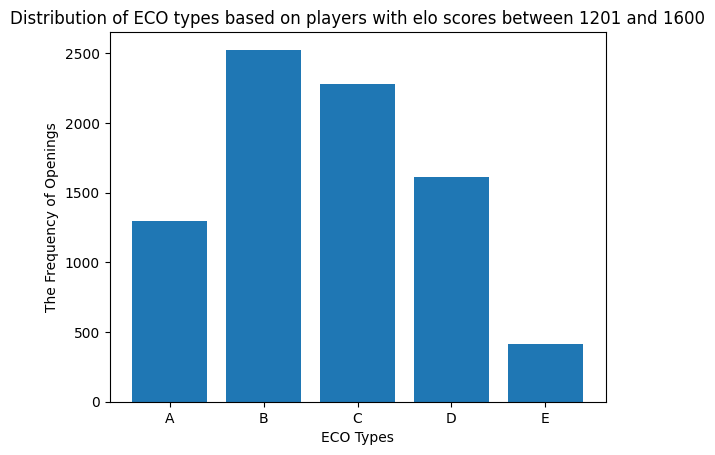

In [ ]:
eco_types = list(eco_data.keys())
values = [data['elo_1201_1600'] for data in eco_data.values()]

# Plotting the distribution
plt.bar(eco_types, values)
plt.xlabel('ECO Types')
plt.ylabel('The Frequency of Openings')
plt.title('Distribution of ECO types based on players with elo scores between 1201 and 1600')
plt.show()


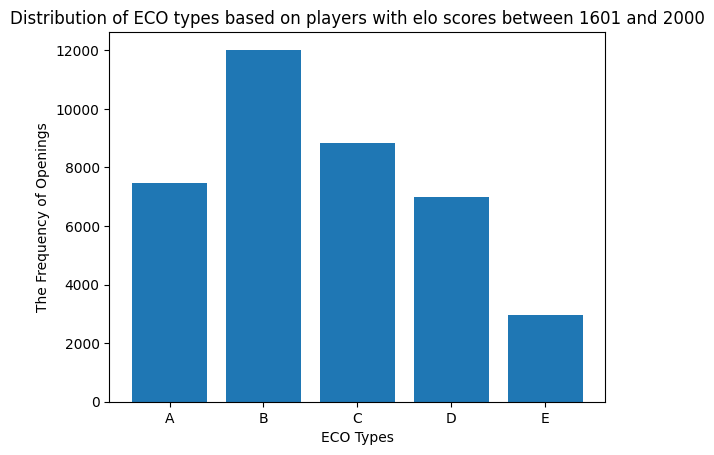

In [ ]:
# Get the ECO types and corresponding elo_800_1200 values
eco_types = list(eco_data.keys())
values = [data['elo_1601_2000'] for data in eco_data.values()]

# Plotting the distribution
plt.bar(eco_types, values)
plt.xlabel('ECO Types')
plt.ylabel('The Frequency of Openings')
plt.title('Distribution of ECO types based on players with elo scores between 1601 and 2000')
plt.show()


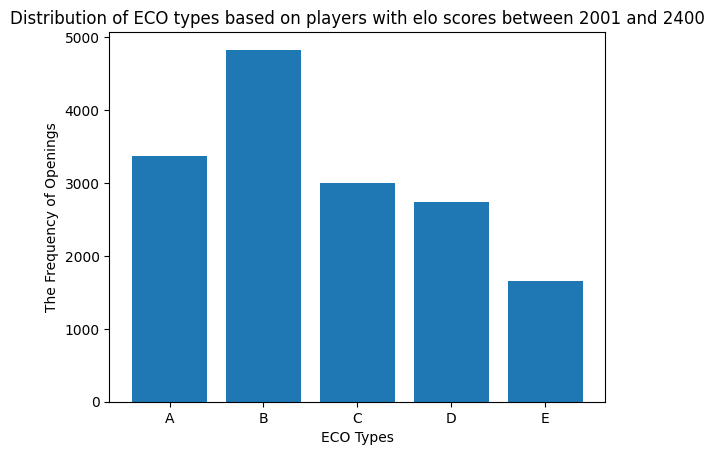

In [ ]:
# Get the ECO types and corresponding elo_800_1200 values
eco_types = list(eco_data.keys())
values = [data['elo_2001_2400'] for data in eco_data.values()]

# Plotting the distribution
plt.bar(eco_types, values)
plt.xlabel('ECO Types')
plt.ylabel('The Frequency of Openings')
plt.title('Distribution of ECO types based on players with elo scores between 2001 and 2400')
plt.show()

In [ ]:
print(f"Number of nodes in players_800_1200_projected_graph: {players_800_1200_projected_graph.number_of_nodes()}")
print(f"Number of nodes in players_1201_1600_projected_graph: {players_1201_1600_projected_graph.number_of_nodes()}")
print(f"Number of nodes in players_1601_2000_projected_graph: {players_1601_2000_projected_graph.number_of_nodes()}")
print(f"Number of nodes in players_2001_2400_projected_graph: {players_2001_2400_projected_graph.number_of_nodes()}")


Number of nodes in players_800_1200_projected_graph: 3171
Number of nodes in players_1201_1600_projected_graph: 3484
Number of nodes in players_1601_2000_projected_graph: 3498
Number of nodes in players_2001_2400_projected_graph: 3498


# Tendency to Use Distinctive Openings

In [ ]:
# Create a dictionary to store player information
player_info = {}

# Iterate over nodes in the network
for node, attrs in B.nodes(data=True):
    # Check if node is a player
    if attrs['label'] == 'player':
        # Get player name and elo score
        player_name = node
        elo_score = attrs['elo']

        # Initialize the openings list for the player
        openings = []

        # Get openings played by the player
        player_openings = [edge for edge in B.edges(player_name) if B.nodes[edge[1]]['label'] == 'ECO']

        for opening in player_openings:
            opening_node = opening[1]
            opening_weight = B.edges[opening]['weight']

            # Add the opening as many times as it was played
            openings.extend([opening_node] * opening_weight)

        # Store player information in the dictionary
        player_info[player_name] = {
            'elo': elo_score,
            'openings': openings
        }

# Print the player_info dictionary
print(player_info)


{'Poldi_der_Drache': {'elo': 2006, 'openings': ['B01', 'D96', 'B21', 'B21', 'B07', 'D85', 'B43', 'B41', 'B41', 'B41', 'A45', 'B33', 'B33', 'B33', 'B33', 'B33', 'B42', 'B42', 'B32', 'B32', 'D91', 'B28', 'D88', 'D01', 'B00', 'A08', 'B92']}, 'izcms02': {'elo': 1878, 'openings': ['D30', 'D30', 'D02', 'D02', 'D02', 'D02', 'E10', 'E06', 'E06', 'E01', 'E67', 'A45', 'A45', 'E85', 'E94', 'E94', 'D10', 'D10', 'E92', 'E92', 'E81', 'E80', 'B00', 'C43', 'E04', 'C60', 'B19', 'C10', 'B07', 'D37', 'B90', 'C42', 'C42', 'A30', 'C11', 'C11', 'C12', 'B51', 'D35', 'C14', 'A04', 'D32', 'C13', 'A41', 'B38', 'A57', 'C97']}, 'pafiedor': {'elo': 1857, 'openings': ['D11', 'D07', 'B40', 'D30', 'A09', 'E00', 'B33', 'B22', 'D06']}, 'M0r1': {'elo': 1985, 'openings': ['B00', 'B00', 'C06', 'C06', 'C06', 'C06', 'C26', 'C26', 'D04', 'D00', 'B10', 'B10', 'B10', 'A05', 'B01', 'B90', 'B90', 'B90', 'B90', 'B90', 'C44', 'C44', 'E62', 'B32', 'B32', 'B32', 'C55', 'C55', 'D31', 'D31', 'B23', 'B23', 'A58', 'A58', 'A58', 'A58', '

In [ ]:
# Create a dictionary to store player information
player_info = {}

# Iterate over nodes in the network
for node, attrs in B.nodes(data=True):
    # Check if node is a player
    if attrs['label'] == 'player':
        # Get player name and elo score
        player_name = node
        elo_score = attrs['elo']

        # Initialize the openings list for the player
        openings = []

        # Get openings played by the player
        player_openings = [edge for edge in B.edges(player_name) if B.nodes[edge[1]]['label'] == 'ECO']

        for opening in player_openings:
            opening_node = opening[1]
            opening_weight = B.edges[opening]['weight']

            # Add the opening as many times as it was played
            openings.extend([opening_node] * opening_weight)

        # Store player information in the dictionary
        player_info[player_name] = {
            'elo': elo_score,
            'openings': openings
        }

# Print the player_info dictionary
print(player_info)



{'Poldi_der_Drache': {'elo': 2006, 'openings': ['B01', 'D96', 'B21', 'B21', 'B07', 'D85', 'B43', 'B41', 'B41', 'B41', 'A45', 'B33', 'B33', 'B33', 'B33', 'B33', 'B42', 'B42', 'B32', 'B32', 'D91', 'B28', 'D88', 'D01', 'B00', 'A08', 'B92']}, 'izcms02': {'elo': 1878, 'openings': ['D30', 'D30', 'D02', 'D02', 'D02', 'D02', 'E10', 'E06', 'E06', 'E01', 'E67', 'A45', 'A45', 'E85', 'E94', 'E94', 'D10', 'D10', 'E92', 'E92', 'E81', 'E80', 'B00', 'C43', 'E04', 'C60', 'B19', 'C10', 'B07', 'D37', 'B90', 'C42', 'C42', 'A30', 'C11', 'C11', 'C12', 'B51', 'D35', 'C14', 'A04', 'D32', 'C13', 'A41', 'B38', 'A57', 'C97']}, 'pafiedor': {'elo': 1857, 'openings': ['D11', 'D07', 'B40', 'D30', 'A09', 'E00', 'B33', 'B22', 'D06']}, 'M0r1': {'elo': 1985, 'openings': ['B00', 'B00', 'C06', 'C06', 'C06', 'C06', 'C26', 'C26', 'D04', 'D00', 'B10', 'B10', 'B10', 'A05', 'B01', 'B90', 'B90', 'B90', 'B90', 'B90', 'C44', 'C44', 'E62', 'B32', 'B32', 'B32', 'C55', 'C55', 'D31', 'D31', 'B23', 'B23', 'A58', 'A58', 'A58', 'A58', '

In [ ]:
# Initialize player info dictionaries
player_info_A, player_info_B, player_info_C, player_info_D, player_info_E = {}, {}, {}, {}, {}

# Initialize the dictionaries in a dictionary for easier processing
player_info_dict = {"A": player_info_A, "B": player_info_B, "C": player_info_C, "D": player_info_D, "E": player_info_E}

# Iterate over nodes in the network
for node, attrs in B.nodes(data=True):
    # Check if node is a player
    if attrs['label'] == 'player':
        # Get player name and elo score
        player_name = node
        elo_score = attrs['elo']

        # Get openings played by the player
        openings = [(edge[1], B.edges[edge]['weight']) for edge in B.edges(player_name) if B.nodes[edge[1]]['label'] == 'ECO']

        for opening_node, opening_weight in openings:
            # Get the first letter of the opening
            opening_first_letter = opening_node[0]

            # Check if this opening starts with one of the letters we're interested in
            if opening_first_letter in player_info_dict:
                # Check if the player's info is already in the corresponding dictionary
                if player_name in player_info_dict[opening_first_letter]:
                    # Add the opening as many times as it was played
                    player_info_dict[opening_first_letter][player_name]['openings'].extend([opening_node] * opening_weight)
                else:
                    # Add the player's name and elo score to the dictionary
                    player_info_dict[opening_first_letter][player_name] = {
                        'elo': elo_score,
                        'openings': [opening_node] * opening_weight
                    }

# Print the player_info dictionaries
for opening_letter, player_info_dict in player_info_dict.items():
    print(f"player_info_{opening_letter}: {player_info_dict}\n")


player_info_A: {'Poldi_der_Drache': {'elo': 2006, 'openings': ['A45', 'A08']}, 'izcms02': {'elo': 1878, 'openings': ['A45', 'A45', 'A30', 'A04', 'A41', 'A57']}, 'pafiedor': {'elo': 1857, 'openings': ['A09']}, 'M0r1': {'elo': 1985, 'openings': ['A05', 'A58', 'A58', 'A58', 'A58', 'A50', 'A11', 'A45', 'A01', 'A01']}, 'b_elyay': {'elo': 2062, 'openings': ['A65', 'A88']}, 'ElChivo': {'elo': 2216, 'openings': ['A21']}, 'cyclop3000': {'elo': 1897, 'openings': ['A45', 'A45', 'A16']}, 'CrazyMerlyn': {'elo': 2103, 'openings': ['A20']}, 'val1313': {'elo': 1976, 'openings': ['A45', 'A45', 'A45', 'A45', 'A45', 'A45', 'A45', 'A45', 'A45', 'A45', 'A45', 'A07', 'A20', 'A06', 'A86', 'A40', 'A40', 'A40', 'A40', 'A40', 'A40', 'A40', 'A57', 'A57', 'A57', 'A57', 'A15', 'A18', 'A04', 'A01', 'A01', 'A46', 'A13', 'A13', 'A70', 'A70', 'A70', 'A50', 'A90', 'A91']}, 'keeto': {'elo': 1585, 'openings': ['A03', 'A13', 'A23', 'A22']}, 'Wealth_and_Taste': {'elo': 1972, 'openings': ['A04', 'A16', 'A16', 'A20', 'A20', 

In [ ]:
def process_player_info(player_info):
    player_data = {}

    for player_name, player_info in player_info.items():
        elo_score = player_info['elo']
        openings = player_info['openings']

        single_openings = []
        multiple_openings = []

        for opening in openings:
            if openings.count(opening) == 1:
                single_openings.append(opening)
            elif openings.count(opening) > 1 and opening not in multiple_openings:
                multiple_openings.append(opening)

        single_openings_count = len(single_openings)
        multiple_openings_count = len(openings) - single_openings_count

        player_data[player_name] = {
            'elo': elo_score,
            'single_openings_count': single_openings_count,
            'multiple_openings_count': multiple_openings_count
        }

    return player_data


player_data = process_player_info(player_info)

print(player_data)



{'Poldi_der_Drache': {'elo': 2006, 'single_openings_count': 13, 'multiple_openings_count': 14}, 'izcms02': {'elo': 1878, 'single_openings_count': 27, 'multiple_openings_count': 20}, 'pafiedor': {'elo': 1857, 'single_openings_count': 9, 'multiple_openings_count': 0}, 'M0r1': {'elo': 1985, 'single_openings_count': 33, 'multiple_openings_count': 58}, 'b_elyay': {'elo': 2062, 'single_openings_count': 11, 'multiple_openings_count': 0}, 'ElChivo': {'elo': 2216, 'single_openings_count': 9, 'multiple_openings_count': 21}, 'cyclop3000': {'elo': 1897, 'single_openings_count': 2, 'multiple_openings_count': 6}, 'CrazyMerlyn': {'elo': 2103, 'single_openings_count': 10, 'multiple_openings_count': 5}, 'chessfefe': {'elo': 1835, 'single_openings_count': 2, 'multiple_openings_count': 2}, 'val1313': {'elo': 1976, 'single_openings_count': 44, 'multiple_openings_count': 110}, 'keeto': {'elo': 1585, 'single_openings_count': 14, 'multiple_openings_count': 41}, 'Wealth_and_Taste': {'elo': 1972, 'single_openi

ASDASDSDFDSFSDF

In [ ]:
player_data_A = process_player_info(player_info_A)
print(player_data_A)

player_data_B = process_player_info(player_info_B)
print(player_data_B)

player_data_C = process_player_info(player_info_C)
print(player_data_C)

player_data_D = process_player_info(player_info_D)
print(player_data_D)

player_data_E = process_player_info(player_info_E)
print(player_data_E)

{'Poldi_der_Drache': {'elo': 2006, 'single_openings_count': 2, 'multiple_openings_count': 0}, 'izcms02': {'elo': 1878, 'single_openings_count': 4, 'multiple_openings_count': 2}, 'pafiedor': {'elo': 1857, 'single_openings_count': 1, 'multiple_openings_count': 0}, 'M0r1': {'elo': 1985, 'single_openings_count': 4, 'multiple_openings_count': 6}, 'b_elyay': {'elo': 2062, 'single_openings_count': 2, 'multiple_openings_count': 0}, 'ElChivo': {'elo': 2216, 'single_openings_count': 1, 'multiple_openings_count': 0}, 'cyclop3000': {'elo': 1897, 'single_openings_count': 1, 'multiple_openings_count': 2}, 'CrazyMerlyn': {'elo': 2103, 'single_openings_count': 1, 'multiple_openings_count': 0}, 'val1313': {'elo': 1976, 'single_openings_count': 11, 'multiple_openings_count': 29}, 'keeto': {'elo': 1585, 'single_openings_count': 4, 'multiple_openings_count': 0}, 'Wealth_and_Taste': {'elo': 1972, 'single_openings_count': 6, 'multiple_openings_count': 7}, 'xkm': {'elo': 1732, 'single_openings_count': 6, 'mu

In [ ]:
player_data_filtered = dict(data for data in player_data.items() if data[1]['single_openings_count'] + data[1]['multiple_openings_count'] > 2)
player_data_filtered_A = dict(data for data in player_data_A.items() if data[1]['single_openings_count'] + data[1]['multiple_openings_count'] > 2)
player_data_filtered_B = dict(data for data in player_data_B.items() if data[1]['single_openings_count'] + data[1]['multiple_openings_count'] > 2)
player_data_filtered_C = dict(data for data in player_data_C.items() if data[1]['single_openings_count'] + data[1]['multiple_openings_count'] > 2)
player_data_filtered_D = dict(data for data in player_data_D.items() if data[1]['single_openings_count'] + data[1]['multiple_openings_count'] > 2)
player_data_filtered_E = dict(data for data in player_data_E.items() if data[1]['single_openings_count'] + data[1]['multiple_openings_count'] > 2)


In [ ]:
print(player_data_filtered)

{'Poldi_der_Drache': {'elo': 2006, 'single_openings_count': 13, 'multiple_openings_count': 14}, 'izcms02': {'elo': 1878, 'single_openings_count': 27, 'multiple_openings_count': 20}, 'pafiedor': {'elo': 1857, 'single_openings_count': 9, 'multiple_openings_count': 0}, 'M0r1': {'elo': 1985, 'single_openings_count': 33, 'multiple_openings_count': 58}, 'b_elyay': {'elo': 2062, 'single_openings_count': 11, 'multiple_openings_count': 0}, 'ElChivo': {'elo': 2216, 'single_openings_count': 9, 'multiple_openings_count': 21}, 'cyclop3000': {'elo': 1897, 'single_openings_count': 2, 'multiple_openings_count': 6}, 'CrazyMerlyn': {'elo': 2103, 'single_openings_count': 10, 'multiple_openings_count': 5}, 'chessfefe': {'elo': 1835, 'single_openings_count': 2, 'multiple_openings_count': 2}, 'val1313': {'elo': 1976, 'single_openings_count': 44, 'multiple_openings_count': 110}, 'keeto': {'elo': 1585, 'single_openings_count': 14, 'multiple_openings_count': 41}, 'Wealth_and_Taste': {'elo': 1972, 'single_openi

In [ ]:
# Iterate through player_data and calculate the ratios
for player_name, data in player_data_filtered.items():
    total_count = data['single_openings_count'] + data['multiple_openings_count']
    data['single_openings_count'] /= total_count
    data['multiple_openings_count'] /= total_count

# Print the updated player_data dictionary
print(player_data)


{'Poldi_der_Drache': {'elo': 2006, 'single_openings_count': 0.48148148148148145, 'multiple_openings_count': 0.5185185185185185}, 'izcms02': {'elo': 1878, 'single_openings_count': 0.574468085106383, 'multiple_openings_count': 0.425531914893617}, 'pafiedor': {'elo': 1857, 'single_openings_count': 1.0, 'multiple_openings_count': 0.0}, 'M0r1': {'elo': 1985, 'single_openings_count': 0.3626373626373626, 'multiple_openings_count': 0.6373626373626373}, 'b_elyay': {'elo': 2062, 'single_openings_count': 1.0, 'multiple_openings_count': 0.0}, 'ElChivo': {'elo': 2216, 'single_openings_count': 0.3, 'multiple_openings_count': 0.7}, 'cyclop3000': {'elo': 1897, 'single_openings_count': 0.25, 'multiple_openings_count': 0.75}, 'CrazyMerlyn': {'elo': 2103, 'single_openings_count': 0.6666666666666666, 'multiple_openings_count': 0.3333333333333333}, 'chessfefe': {'elo': 1835, 'single_openings_count': 0.5, 'multiple_openings_count': 0.5}, 'val1313': {'elo': 1976, 'single_openings_count': 0.2857142857142857, 

In [ ]:
# Iterate through player_data and calculate the ratios
for player_name, data in player_data_filtered_A.items():
    total_count = data['single_openings_count'] + data['multiple_openings_count']
    data['single_openings_count'] /= total_count
    data['multiple_openings_count'] /= total_count

# Iterate through player_data and calculate the ratios
for player_name, data in player_data_filtered_B.items():
    total_count = data['single_openings_count'] + data['multiple_openings_count']
    data['single_openings_count'] /= total_count
    data['multiple_openings_count'] /= total_count

# Iterate through player_data and calculate the ratios
for player_name, data in player_data_filtered_C.items():
    total_count = data['single_openings_count'] + data['multiple_openings_count']
    data['single_openings_count'] /= total_count
    data['multiple_openings_count'] /= total_count

# Iterate through player_data and calculate the ratios
for player_name, data in player_data_filtered_D.items():
    total_count = data['single_openings_count'] + data['multiple_openings_count']
    data['single_openings_count'] /= total_count
    data['multiple_openings_count'] /= total_count

# Iterate through player_data and calculate the ratios
for player_name, data in player_data_filtered_E.items():
    total_count = data['single_openings_count'] + data['multiple_openings_count']
    data['single_openings_count'] /= total_count
    data['multiple_openings_count'] /= total_count

In [ ]:
print(player_data_filtered_D)

{'Poldi_der_Drache': {'elo': 2006, 'single_openings_count': 1.0, 'multiple_openings_count': 0.0}, 'izcms02': {'elo': 1878, 'single_openings_count': 0.2727272727272727, 'multiple_openings_count': 0.7272727272727273}, 'pafiedor': {'elo': 1857, 'single_openings_count': 1.0, 'multiple_openings_count': 0.0}, 'M0r1': {'elo': 1985, 'single_openings_count': 0.5, 'multiple_openings_count': 0.5}, 'ElChivo': {'elo': 2216, 'single_openings_count': 0.2857142857142857, 'multiple_openings_count': 0.7142857142857143}, 'CrazyMerlyn': {'elo': 2103, 'single_openings_count': 1.0, 'multiple_openings_count': 0.0}, 'val1313': {'elo': 1976, 'single_openings_count': 0.2857142857142857, 'multiple_openings_count': 0.7142857142857143}, 'keeto': {'elo': 1585, 'single_openings_count': 0.0, 'multiple_openings_count': 1.0}, 'Wealth_and_Taste': {'elo': 1972, 'single_openings_count': 1.0, 'multiple_openings_count': 0.0}, 'chatakkuma': {'elo': 2158, 'single_openings_count': 0.38095238095238093, 'multiple_openings_count'

In [ ]:
max_elo = max(player_data_filtered.values(), key=lambda x: x['elo'])['elo']
print("Max Elo:", max_elo)

Max Elo: 2544


In [ ]:
elo_ranges = {}

# Generate elo ranges and initialize values
for lower_bound in range(0, 2501, 50):
    upper_bound = lower_bound + 50
    elo_range = f"{lower_bound}-{upper_bound}"
    elo_ranges[elo_range] = {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}

# Print the elo ranges dictionary
for elo_range, values in elo_ranges.items():
    print(elo_range, values)

0-50 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
50-100 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
100-150 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
150-200 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
200-250 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
250-300 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
300-350 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
350-400 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
400-450 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
450-500 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
500-550 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
550

In [ ]:
elo_ranges = {}

# Generate elo ranges and initialize values
for lower_bound in range(0, 2501, 50):
    upper_bound = lower_bound + 50
    elo_range = f"{lower_bound}-{upper_bound}"
    elo_ranges[elo_range] = {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}

# Iterate through player_data_filtered
for player_info in player_data_filtered.values():
    elo_score = player_info['elo']
    single_openings_count = player_info['single_openings_count']
    multiple_openings_count = player_info['multiple_openings_count']

    # Find the elo range for the player
    elo_range = None
    for key in elo_ranges.keys():
        lower_bound, upper_bound = map(int, key.split('-'))
        if lower_bound <= elo_score <= upper_bound:
            elo_range = key
            break

    # Update the elo range in elo_ranges dictionary
    if elo_range:
        elo_ranges[elo_range]['single_openings_ratio'] += single_openings_count
        elo_ranges[elo_range]['multiple_openings_ratio'] += multiple_openings_count
        elo_ranges[elo_range]['times_added'] += 1.0

# Print the updated elo_ranges dictionary
for elo_range, values in elo_ranges.items():
    print(elo_range, values)



0-50 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
50-100 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
100-150 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
150-200 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
200-250 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
250-300 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
300-350 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
350-400 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
400-450 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
450-500 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
500-550 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
550

In [ ]:
for values in elo_ranges.values():
    times_added = values['times_added']
    if times_added != 0:
        values['single_openings_ratio'] *= 1/times_added
        values['multiple_openings_ratio'] *= 1/times_added

# Print the updated elo_ranges dictionary
for elo_range, values in elo_ranges.items():
    print(elo_range, values)



0-50 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
50-100 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
100-150 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
150-200 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
200-250 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
250-300 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
300-350 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
350-400 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
400-450 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
450-500 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
500-550 {'single_openings_ratio': 0.0, 'multiple_openings_ratio': 0.0, 'times_added': 0.0}
550

In [ ]:
# Create a new dictionary to store the filtered elo_ranges
filtered_elo_ranges = {}

# Iterate over the items in elo_ranges
for elo_range, values in elo_ranges.items():
    times_added = values['times_added']
    if times_added >= 10:
        # Add the item to the filtered_elo_ranges dictionary
        filtered_elo_ranges[elo_range] = values

# Update elo_ranges with the filtered dictionary
elo_ranges = filtered_elo_ranges

# Print the filtered elo_ranges dictionary
for elo_range, values in elo_ranges.items():
    print(elo_range, values)


1250-1300 {'single_openings_ratio': 0.7254776473526474, 'multiple_openings_ratio': 0.2745223526473526, 'times_added': 16.0}
1300-1350 {'single_openings_ratio': 0.6936995265942634, 'multiple_openings_ratio': 0.3063004734057366, 'times_added': 18.0}
1350-1400 {'single_openings_ratio': 0.7243564135456525, 'multiple_openings_ratio': 0.27564358645434767, 'times_added': 31.0}
1400-1450 {'single_openings_ratio': 0.7360992758025529, 'multiple_openings_ratio': 0.26390072419744726, 'times_added': 57.0}
1450-1500 {'single_openings_ratio': 0.6906901245143192, 'multiple_openings_ratio': 0.3093098754856809, 'times_added': 70.0}
1500-1550 {'single_openings_ratio': 0.739622860282926, 'multiple_openings_ratio': 0.26037713971707377, 'times_added': 88.0}
1550-1600 {'single_openings_ratio': 0.7206144681480711, 'multiple_openings_ratio': 0.279385531851929, 'times_added': 118.0}
1600-1650 {'single_openings_ratio': 0.685413583999014, 'multiple_openings_ratio': 0.3145864160009862, 'times_added': 172.0}
1650-1

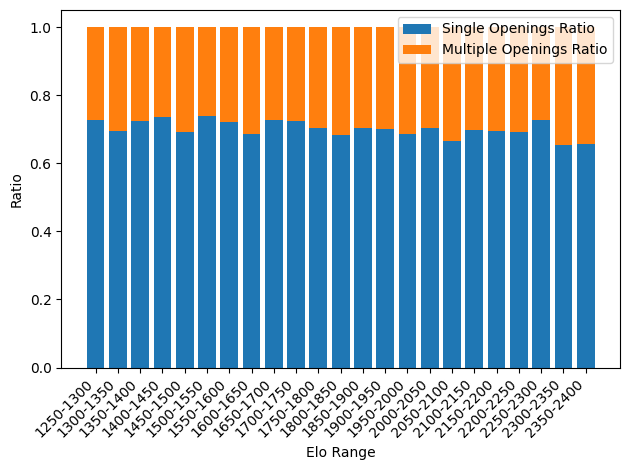

In [ ]:
# Initialize lists to store the x-axis labels, single openings ratios, and multiple openings ratios
x_labels = []
single_openings_ratios = []
multiple_openings_ratios = []

# Iterate over the elo_ranges dictionary
for elo_range, values in elo_ranges.items():
    x_labels.append(elo_range)
    single_openings_ratios.append(values['single_openings_ratio'])
    multiple_openings_ratios.append(values['multiple_openings_ratio'])

# Create a bar plot using matplotlib
fig, ax = plt.subplots()

# Set the x-axis labels and their positions
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Create the bars for single openings and multiple openings
ax.bar(range(len(x_labels)), single_openings_ratios, label='Single Openings Ratio')
ax.bar(range(len(x_labels)), multiple_openings_ratios, bottom=single_openings_ratios, label='Multiple Openings Ratio')

# Set the legend and labels
ax.legend()
ax.set_xlabel('Elo Range')
ax.set_ylabel('Ratio')

# Show the plot
plt.tight_layout()
plt.show()


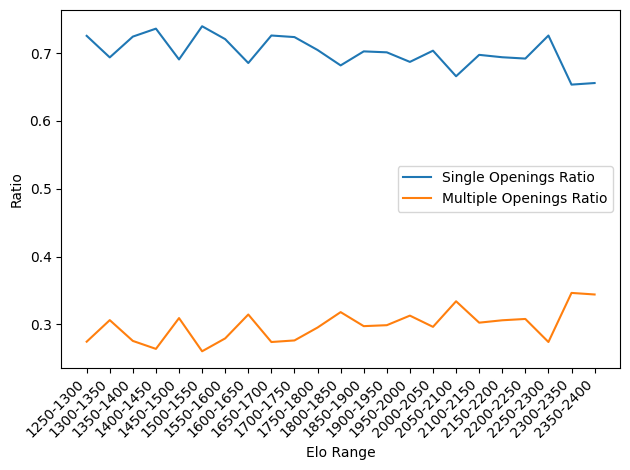

In [ ]:
# Convert the elo_ranges dictionary to a list of tuples for sorting
elo_ranges_sorted = sorted(elo_ranges.items())

# Extract the elo ranges and the corresponding ratios
elo_ranges_labels = [elo_range for elo_range, _ in elo_ranges_sorted]
single_openings_ratios = [values['single_openings_ratio'] for _, values in elo_ranges_sorted]
multiple_openings_ratios = [values['multiple_openings_ratio'] for _, values in elo_ranges_sorted]

# Plot the single openings ratio
plt.plot(elo_ranges_labels, single_openings_ratios, label='Single Openings Ratio')

# Plot the multiple openings ratio
plt.plot(elo_ranges_labels, multiple_openings_ratios, label='Multiple Openings Ratio')

# Set the x-axis labels and rotation
plt.xticks(rotation=45, ha='right')

# Set the legend and labels
plt.legend()
plt.xlabel('Elo Range')
plt.ylabel('Ratio')

# Show the plot
plt.tight_layout()
plt.show()
